# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# keep matplotlib interactive
# NOTE: one must reload matplotlib to change of rendering style
%matplotlib notebook
# %matplotlib inline
# use ggplot style
plt.style.use('ggplot')

# Churn Prediction

Any subscription-based business is committed to keep their customer happy in exchange for their loyalty. Despite their efforts, some customers will eventually not renew their subscription. In this latter case, if a customer has not renewed within a time window after its subscription expiration date, this customer is said to have churned. Although each service provider offers several subscription options (monthly, yearly, basic, premium,...), the time window to consider a customer has churned varies quite a lot. It seems that each company sets their own.

This project is based on a [Kaggle competition](https://www.kaggle.com/c/kkbox-churn-prediction-challenge) where KKBOX, an Asian leading __music streaming service__, is interested in learning from their customer behavior to prevent them from churning.

The __grace period is 30 days__ in order to consider a customer has churned after its current membership ends. The goal is to determine churn from one month to the next.

In [2]:
# train.csv only contains 
train_dir = os.path.join(os.pardir, 'data', 'raw', 'train.csv')
df_train = pd.read_csv(train_dir, index_col = 'msno')

In [3]:
df_train.head()

,is_churn
msno,
waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=,1
QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=,1
fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=,1
mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=,1
XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 992931 entries, waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y= to ZoVEIVMCpKT9/MJgqO+fh9xYrNM2vNisLhJ4xY/CVyk=
Data columns (total 1 columns):
is_churn    992931 non-null int64
dtypes: int64(1)
memory usage: 15.2+ MB


In [5]:
# _ , axChurn = plt.subplots(figsize=(10, 2))

# # one could histogram is_churn column directly but it doesn't look good
# # df_train.is_churn.plot(kind='hist', bins=[0, 1, 2], rwidth=0.5, align = 'left', ax=axChurn)

# # histogram via value_counts() then make bar plot, change ticks labels
# # churn_distrib = df_train.is_churn.value_counts()
# # churn_distrib.plot(kind='barh', ax=axChurn)
# # axChurn.set_yticklabels(('No Churn', 'Churn'), rotation = 0)
# ## plt.xticks(churn_distrib.index, ('No Churn', 'Churn'), rotation = 0)

<IPython.core.display.Javascript object>


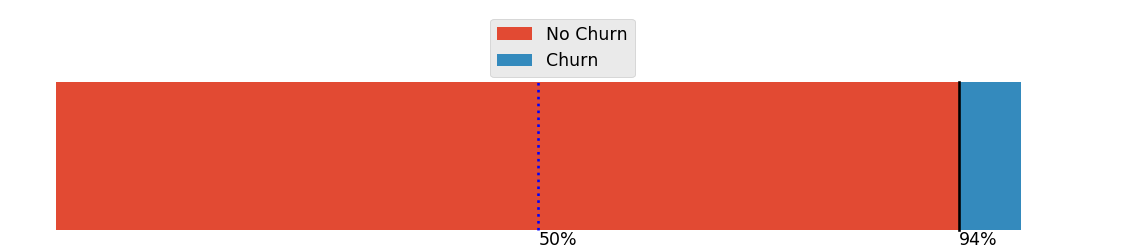

(0.0, 1.05, -0.44000000000000006, 0.44000000000000006)

In [6]:
# axes configuration
_ , axChurn = plt.subplots(figsize=(9, 2))
axChurn.set_position([0.05, 0.05, 0.9, 0.65])

# histogram via value_counts()
churn_distrib = df_train.is_churn.value_counts(normalize=True)

# bar plot of no churn first
no_churn = churn_distrib.loc[0]
axChurn.barh(0, no_churn)

# bar plot of churn stacked on no churn horizontally
h_bar2 = axChurn.barh(0, churn_distrib.loc[1],  left = no_churn)

# add legend
axChurn.legend(['No Churn', 'Churn'], bbox_to_anchor=(0.5,1.4), loc = 'upper center')

# show a line at 50% if it were balanced
bar_height = h_bar2.patches[-1].get_height()/2
axChurn.plot([0.5]*2, [-bar_height, bar_height], color = 'b', linestyle = ':')
axChurn.text(0.5,-bar_height*1.2, '50%')

# show a line at the atually split of no churn - churn
axChurn.plot([no_churn]*2, [-bar_height, bar_height], color = 'k', linestyle = '-')
axChurn.text(no_churn,-bar_height*1.2, '{:.0f}%'.format(no_churn*100))

# removes axis spines altogether
axChurn.axis('off')

# Data Description
There 3 data files that can tell us about customer behavior.

                                                

|                                       transactions.csv                                        |
|-----------------------------------------------------------------------------------------------|
| msno                   | user id  (letters, digits and special characters)                    |
| payment_method_id      | payment method   (masked)                                            |
| payment_plan_days      | length of membership plan in days                                    |
| plan_list_price        | in New Taiwan Dollar (NTD)                                           |
| actual_amount_paid     | in New Taiwan Dollar (NTD)                                           |
| is_auto_renew          | true when customer opted in renewing its subscription automatically  |
| transaction_date       | format %Y%m%d                                                        |
| membership_expire_date | format %Y%m%d                                                        |
| is_cancel              | whether or not the user canceled the membership in this transaction. |



|              user_logs.csv                                              |
|-------------------------------------------------------------------------|
| msno       | user id  (letters, digits and special characters)          |
| date       | format %Y%m%d                                              |
| num_25     | # of songs played less than 25% of the song length         |
| num_50     | # of songs played between 25% to 50% of the song length    |
| num_75     | # of songs played between 50% to 75% of of the song length |
| num_985    | # of songs played between 75% to 98.5% of the song length  |
| num_100    | # of songs played over 98.5% of the song length            |
| num_unq    | # of unique songs played                                   |
| total_secs | total seconds played                                       |

|                                    members.csv                  |
|---------------------------------|-------------------------------|
| msno                            |user id  (letters, digits and special characters) |
| city                            |          name of city         |
| bd                              | age$^i$                       |
| gender                          |            gender             |
| registered_via                  |     registration method       |
| registration_init_time          |          format %Y%m%d        |
| expiration_date                 | format %Y%m%d $^{ii}$         |

$^i$Note: this column has outlier values ranging from -7000 to 2015 please use your judgement.

$^{ii}$Note: taken as a snapshot at which the member.csv is extracted. Not representing the actual churn behavior.

### Transactions

In [7]:
transaction_dir = os.path.join(os.pardir, 'data', 'raw', 'transactions.csv')
df_transac = pd.read_csv(transaction_dir, index_col = 'msno', parse_dates=['transaction_date', 'membership_expire_date'])

In [8]:
df_transac.count()

payment_method_id         21547746
payment_plan_days         21547746
plan_list_price           21547746
actual_amount_paid        21547746
is_auto_renew             21547746
transaction_date          21547746
membership_expire_date    21547746
is_cancel                 21547746
dtype: int64

In [9]:
# treat payment_method_id as a category
df_transac.payment_method_id = df_transac.payment_method_id.astype('category')
# convert relevant columns to boolean
df_transac.is_auto_renew = df_transac.is_auto_renew.astype(bool)
df_transac.is_cancel = df_transac.is_cancel.astype(bool)

In [10]:
df_transac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21547746 entries, YyO+tlZtAXYXoZhNr3Vg3+dfVQvrBVGO8j1mfqe4ZHc= to oE4y2wK5E7OR8zyrCHeW02uTeI6wTwT4QTApEVBNEdM=
Data columns (total 8 columns):
payment_method_id         category
payment_plan_days         int64
plan_list_price           int64
actual_amount_paid        int64
is_auto_renew             bool
transaction_date          datetime64[ns]
membership_expire_date    datetime64[ns]
is_cancel                 bool
dtypes: bool(2), category(1), datetime64[ns](2), int64(3)
memory usage: 1.0+ GB


In [11]:
def plot_bar(df, bar_list, is_Norm=True):
    """
        Make a bar plot using dataframe df and associated columns in bar_list
        is_Norm will normalize distribution by counts
        df: pandas DataFrame
        bar_list: list of column names
    """
    # keep 2 columns and compute number of rows needed in subpots
    subrows = int(np.ceil(len(bar_list) / 2))
    discard_last_ax = bool(len(bar_list) % 2)
    
    # special case when there is only one column specified
    # then keep one figure and make it bigger
    if subrows == 1 and discard_last_ax:
        _ , ax = plt.subplots(figsize=(9,5))
        ax = [ax]
    else:
        _ , ax = plt.subplots(subrows, 2)
        ax = ax.flatten()
    for k, colname in enumerate(bar_list):
        
        # select column and make bar plot
        s_colname = df[colname]
        distrib = s_colname.value_counts(normalize = is_Norm).sort_index()*100
        distrib.plot(kind='bar', ax=ax[k], color='b')
        
        # add percent character to y tick label if plot normalized
        if is_Norm:
            # add percent on y axis labels, uses numerical value of each tick (just in case scale has changed)
            ax[k].set_yticklabels([ '{:.0f}%'.format(l)  for l in ax[k].get_yticks()])
        else:
            ax[k].set_ylabel('Count')
                
        # reformat existing x ticklabels to integer (may not be required)
        # When numeric columns have Nans then it will show float number
        # ax[k].set_xticklabels([ '{:.0f}'.format(float(l.get_text()))  for l in ax[k].get_xticklabels()])
        
        # add title
        ax[k].set_title(distrib.name + ' Distribution')
        
        # reset x axis label to 45 rotation
        ax[k].tick_params(axis = 'x', rotation = 45)
        
        # add x axis label
        ax[k].set_xlabel(distrib.name)
        
    # decide to keep last axes
    if discard_last_ax and subrows > 1: ax[-1].set_visible(False)
    plt.tight_layout()

### Payment ID method
Payment ID 41 represents more than 50% of transactions

<IPython.core.display.Javascript object>


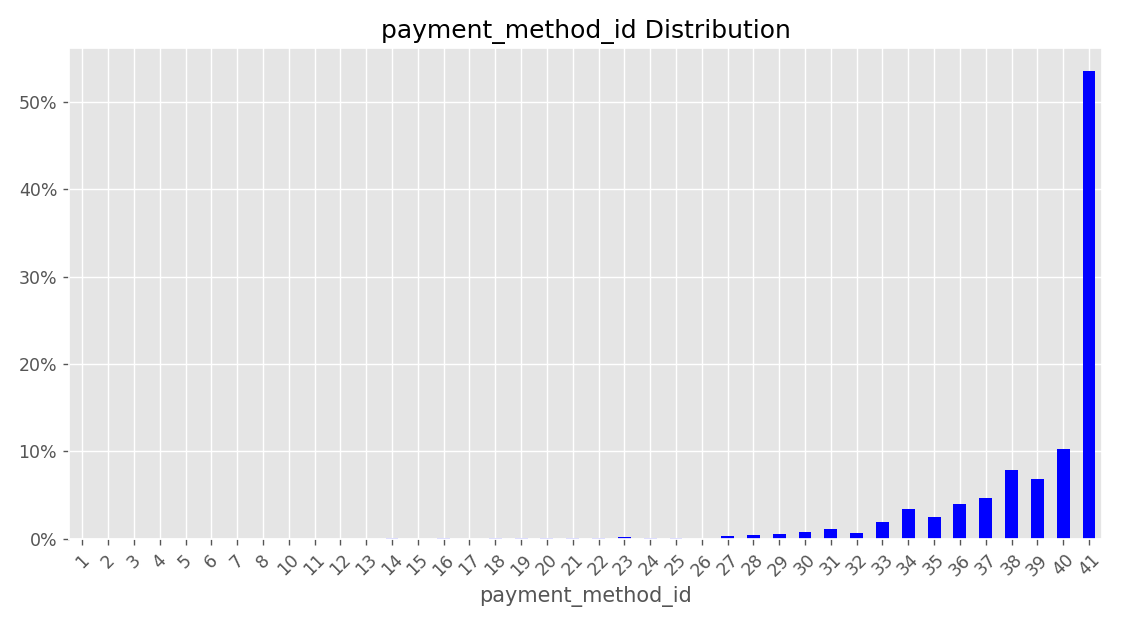

In [12]:
plot_bar(df_transac, ['payment_method_id'])

### Payment Plan in days
There is a lot more variety in subscriptions than I expected
From [KKBOX website](https://help.kkbox.com/hk/zh-tw/billing/pay-types/260), here are the options:
1. Options are monthly plan (30/31 days) with automatic renewal (is_auto_renew true) 
2. Single purchase, no automatic renewal but more expensive:
    3. 30 days
    4. 90 days (plus 7 days bonus?)
    5. 180 days (plus 21 days bonus?)
    6. 365 days (plus 50 days bonus?)
There are discount programs too (getting a credit card with their partners and so on)

0 days doesn't make sense. Because it is low percentage, we can discard it.

We may want to keep only plans shorter than 30/31 days as predicitons are made on a monthly basis.
Indeed, longer subscription means customer will not churn next month

<IPython.core.display.Javascript object>


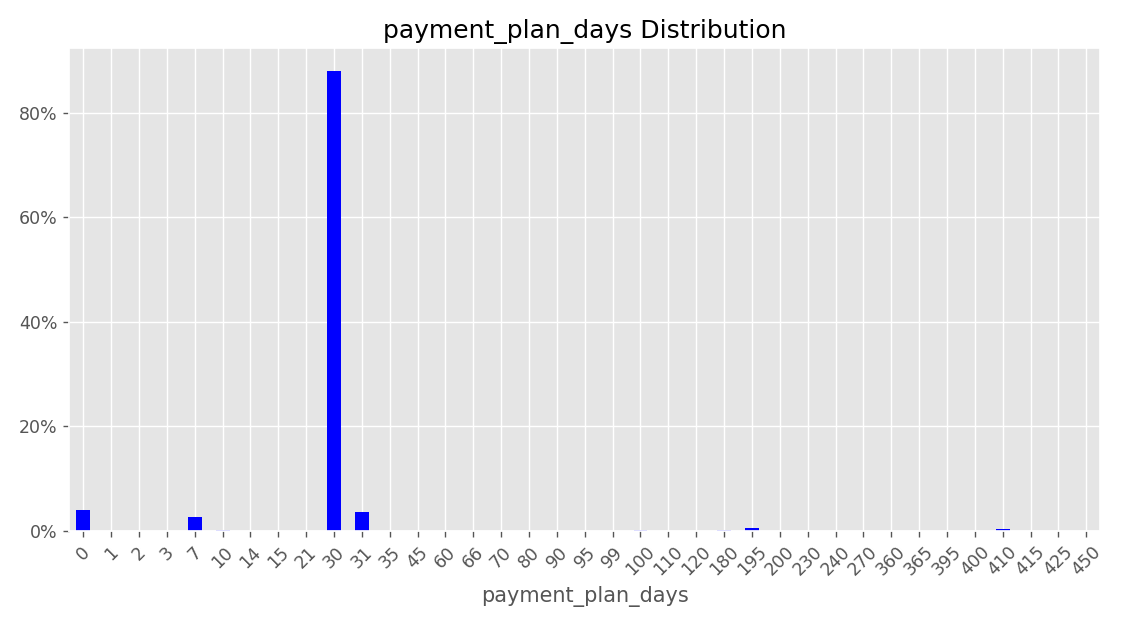

In [13]:
plot_bar(df_transac, ['payment_plan_days'])

### Auto-renew and active cancellation
People who have auto renewal active also don't cancel actively. It is consitent with the fact that most customers don't churn.

<IPython.core.display.Javascript object>


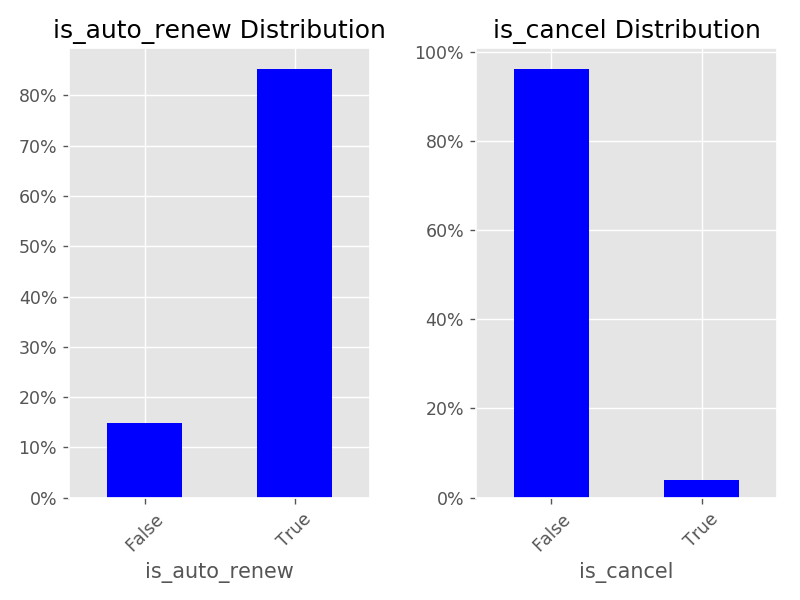

In [14]:
plot_bar(df_transac, ['is_auto_renew' , 'is_cancel'])

### Plan list price
Plan prices are rather discrete therefore there could be categorized for analysis.<br>
Notice some transactions were free probably due to trial period or initial offering. Although, I would expect the actual price paid to be zero. <br>
PS: Plan prices greater than 180 NTD only represents 2% of all transactions.

In [15]:
df_transac.plan_list_price.quantile(q = 0.98)

180.0

<IPython.core.display.Javascript object>


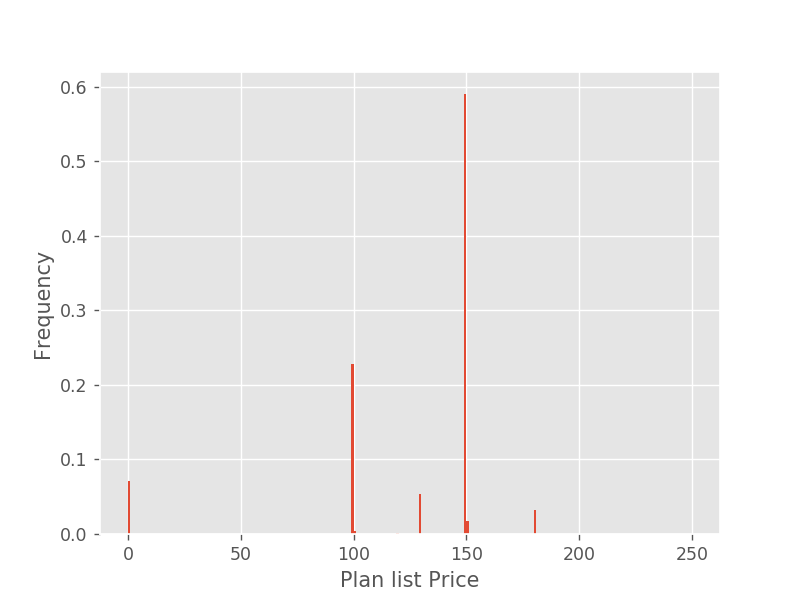

In [16]:
_ , axListPrice = plt.subplots()
_ = df_transac.plan_list_price.plot(kind = 'hist', \
                                bins = 250, range = (0,250), density = True,\
                                ax = axListPrice)
_ = axListPrice.set_xlabel('Plan list Price')

### Subscription cost per subscription length
How do subscription length scale with list price ? <br>
First, let's group plan duration by the following intervals in days:
| 0 - 7 | 8 - 29 | 30 - 89 | 90 - 179 | 180 - 364  | 365 - 450 |


In [17]:
# create custom intervals (bin edges will be left inclusive) in increasing order
days_plan = [0, 8, 30, 90, 180, 365, 451 ]

# compile labels
days_plan_upperbounds = [d-1 for d in days_plan[1:-1] ]
days_plan_upperbounds.append(days_plan[-1])
days_plan_labels = [ "{} - {}".format(l,u) for l,u in zip(days_plan[:-1], days_plan_upperbounds) ]

print('Bin edges = {}'.format(days_plan))
print('Associated labels = {}'.format(days_plan_labels))

Bin edges = [0, 8, 30, 90, 180, 365, 451]
Associated labels = ['0 - 7', '8 - 29', '30 - 89', '90 - 179', '180 - 364', '365 - 451']


In [18]:
# create new column with plan duration category
df_transac['plan_duration'] = pd.cut(df_transac.payment_plan_days, days_plan, right=False, labels=days_plan_labels)

Create bar plot for each auto renew state (True or False) and observe the list price going up with subscription length globally.<br> Free subscription are available across all subscription length.

<IPython.core.display.Javascript object>


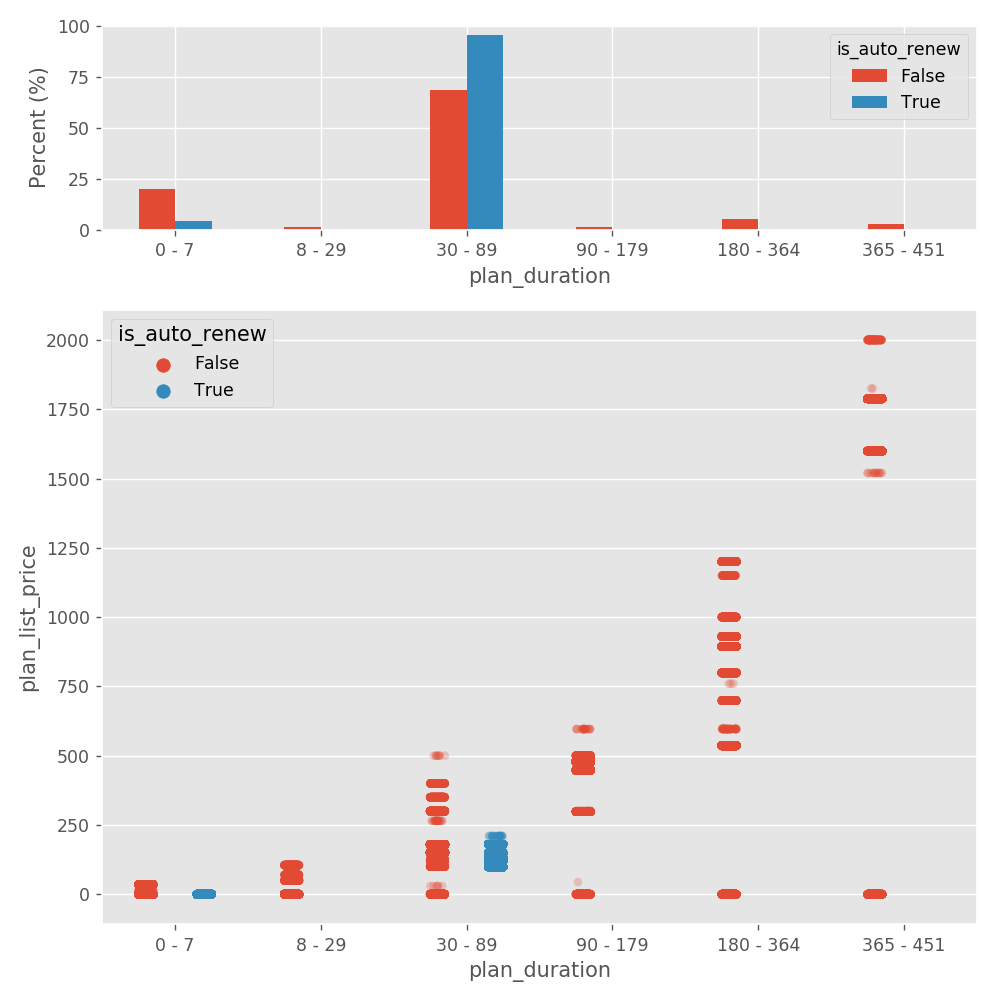

In [19]:
# prepare axis
_ , axCostDays = plt.subplots(2, 1, \
                              figsize=(8, 8), \
                              gridspec_kw=dict(height_ratios=[1, 3]))

# pivot on relevant columns, values can be anything as we are just counting here
df_plan = df_transac.pivot_table(index = 'plan_duration', columns = 'is_auto_renew',\
                                 values = 'plan_list_price', aggfunc = 'count', fill_value = 0)

# normalize each column by counts
df_plan = df_plan.divide(df_plan.sum()) * 100

# make a bar plot for each auto renew state
df_plan.plot(kind = 'bar', ax = axCostDays[0])

# change tick orientation and add labels
axCostDays[0].tick_params(axis = 'x', rotation = 0)
axCostDays[0].set_ylabel('Percent (%)')
axCostDays[0].set_xlabel('plan_duration')


# use seaborn to add plan list price as another dimension
sns.stripplot(x="plan_duration", y="plan_list_price", hue = 'is_auto_renew',\
              dodge = True, jitter = True, alpha = 0.25,\
              data=df_transac, ax = axCostDays[1])
# sns.swarmplot(x="plan_duration", y="plan_list_price", hue = 'is_auto_renew',\
#               dodge = True, alpha = 0.25,\
#               data=df_transac, ax = axCostDays[1])

plt.tight_layout()

The Empirical cumulative distribution function (ECDF) can give us another view when there are too many points to plot.

<IPython.core.display.Javascript object>


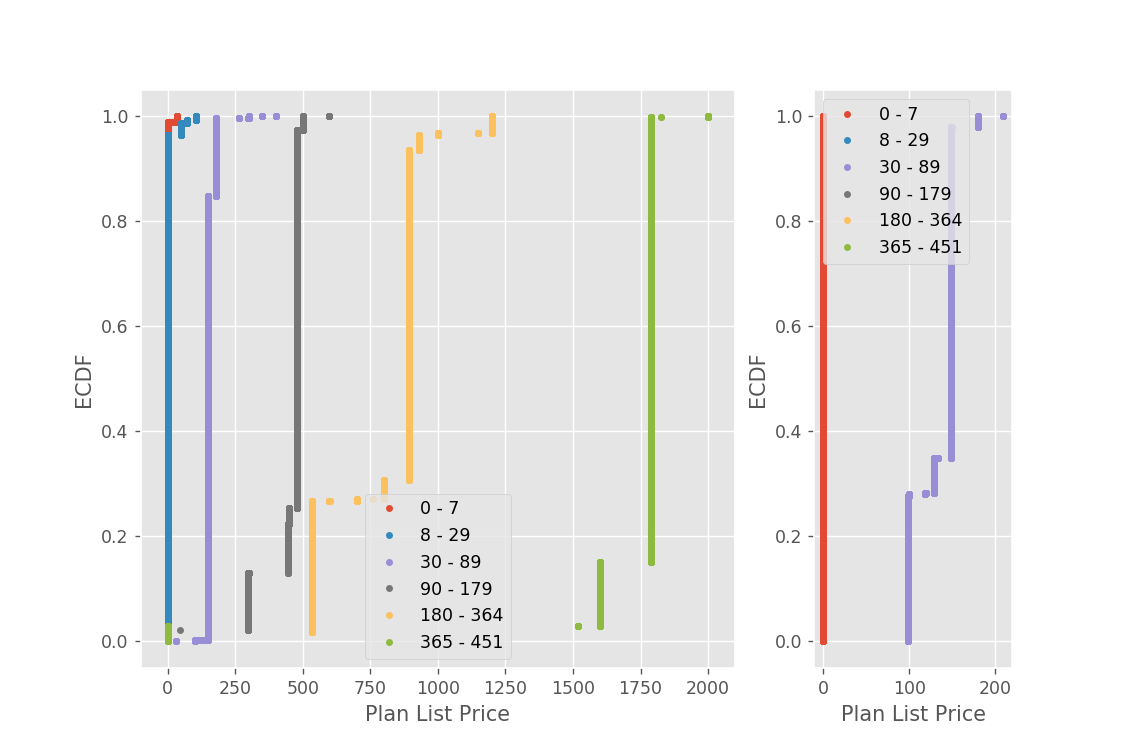

In [20]:
_ , axEcdf = plt.subplots(1, 2, figsize=(9, 6), gridspec_kw=dict(width_ratios=[3, 1]))

for i in range(2):
    # sort your data and plot it versus its percentage increment
    for pl in days_plan_labels:
        filt_pl = (df_transac.is_auto_renew == i ) & (df_transac.plan_duration == pl)
        pl_x = df_transac.loc[filt_pl, 'plan_list_price'].sort_values().values
        pl_y = np.arange(1, len(pl_x)+1) / len(pl_x)
        axEcdf[i].plot(pl_x, pl_y, '.')
        axEcdf[i].set_xlabel('Plan List Price')
        axEcdf[i].set_ylabel('ECDF')
    axEcdf[i].legend(days_plan_labels)

### List price vs paid price
If we compile the percent discount between actual amount and list price (assuming actual amount is always lower or equal to list price), some value will be infinity between we would divide by 0 (when x->0 (1/x)->Inf) <br>
So we should filter out those events that represents ~ 7.5% of all transactions.

In [21]:
df_discount = df_transac[~(df_transac.plan_list_price == 0)]

In [22]:
# percent difference between plan price and price actually paid
discount_percent = 1 - (df_discount.actual_amount_paid/df_discount.plan_list_price)

It appears that an overwhelming majority of transcations do not have any discount (more than 95%).<br>
Note: bin width is 0.1 thus normalization is multiplied by 10 (divided by 0.1). It means 100% corresponds to 10 on the y scale.

<IPython.core.display.Javascript object>


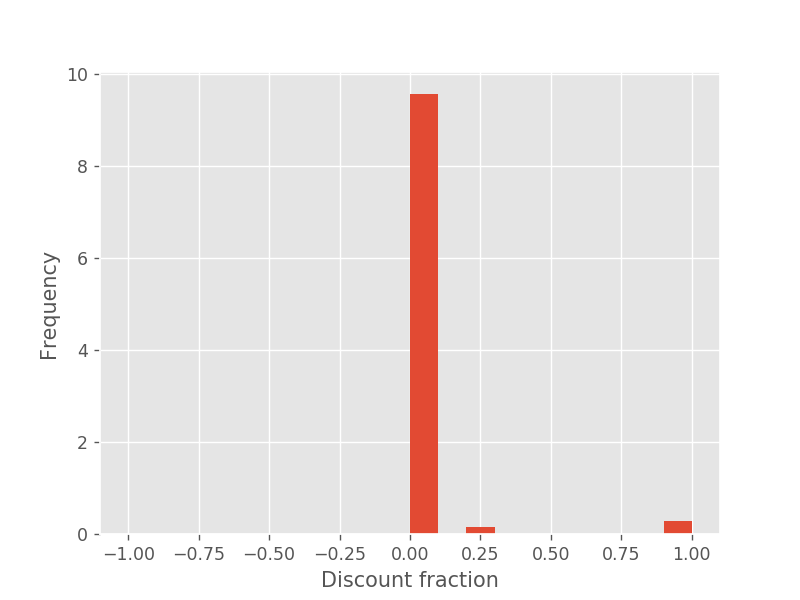

In [23]:
# plot histogram of discounts
_ , axDiscount = plt.subplots()

# plot histogram, bin by 10% intervals
_ = discount_percent.plot(kind = 'hist', range = (-1,1), bins = 20, ax = axDiscount, density = True)

_ = axDiscount.set_xlabel('Discount fraction')

### Transaction and expiration dates
Transactions start in January 2015 up to February 2017. <br>
Membership expiration date takes into account the result of this transaction. For instance, a user who signs up for 2 months will have a membership expiration date 2 months after transaction date. In constrast, a user who actively cancels his plan is recorded as a transaction where expiration date is typically the day after transaction date.

In [24]:
df_transac.transaction_date.describe()

count                21547746
unique                    790
top       2016-08-31 00:00:00
freq                   203688
first     2015-01-01 00:00:00
last      2017-02-28 00:00:00
Name: transaction_date, dtype: object

In [25]:
# compute difference in time between expiration date and transaction date
deltaTransacDate = df_transac.membership_expire_date - df_transac.transaction_date

# convert timedelta to days (it will produce integer)
deltaTransacDate = deltaTransacDate.astype('timedelta64[D]')

# convert timedelta object to days (keep decimals)
# deltaTransacDate = deltaTransacDate/pd.Timedelta('1 day')
# deltaTransacDate = deltaTransacDate/np.timedelta64(1, 'D')

Without surprise, most people renew their membership for 30 or 31 days (Most popular plan). There are other smaller peaks at 0 day, 60 days and 90 days. Users who actively cancels is represented by the 0 day peak.

<IPython.core.display.Javascript object>


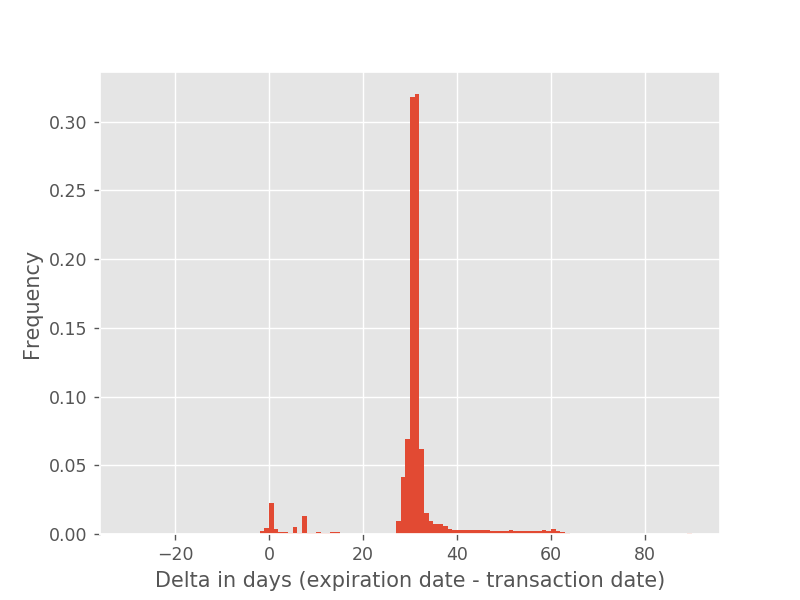

In [26]:
# histogram days, matplotlib hist composes bin with right edge excluded EXCEPT for the last bin
_ , axTransacDate = plt.subplots()

_ = deltaTransacDate.plot(kind = 'hist', range= (-30, 90), bins = 120, density = True, ax = axTransacDate)

_ = axTransacDate.set_xlabel('Delta in days (expiration date - transaction date)')

# NOTE: there are some unrealistic out of range values like -17599 days